In [2]:
%matplotlib inline
import os
import tqdm
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import glob
import json 
import plotnine as pn
import matplotlib.pyplot as plt
import collections
from tcre.env import *
from tcre.supervision import get_candidate_classes, SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN, SPLIT_MAP
from tcre.exec.v1 import optim
from tcre.modeling import features
from snorkel.learning.utils import LabelBalancer
from snorkel import SnorkelSession
from snorkel.models import Candidate
import logging
session = SnorkelSession()
%run ../src/tcre/logging.py
classes = get_candidate_classes()

/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#output_dir = osp.join(RESULTS_DATA_DIR, 'training-classifier', 'run1') # W supervised LFs
output_dir = osp.join(RESULTS_DATA_DIR, 'training-classifier', 'run2')  # W/o supervised LFs
output_dir

'/lab/data/results/training-classifier/run2'

In [4]:
tasks = [classes[c].field for c in classes]
tasks

['inducing_cytokine', 'secreted_cytokine', 'inducing_transcription_factor']

### Initialize Optimizers

In [5]:
from skopt.space import Categorical
from skopt.space import Space

# inducing cytokine: {'marker_list': 'doub_01', 'use_secondary': True, 'use_swaps': True, 'use_positions': True, 'wrd_embedding_type': 'w2v_trained', 
# 'model_size': 'XXXXL', 'weight_decay': 0.0, 'learning_rate': 0.01, 'dropout': 0.75, 'cell_type': 'LSTM', 'bidirectional': False, 
# 'score': 0.521739130434782, 'task': 'inducing_cytokine', 'iteration': 0}
space = Space([
    Categorical(['doub_01'], name='marker_list'),
    Categorical([True, False], name='use_secondary'),
    Categorical([True], name='use_swaps'),
    Categorical([True], name='use_positions'),
    Categorical(['w2v_frozen', 'w2v_trained'], name='wrd_embedding_type'),
    Categorical(['XL', 'XXL', 'XXXL', 'XXXXL'], name='model_size'),
    Categorical([0.0, .0001, .001, .005], name='weight_decay'),
    Categorical([.005, .01, .05], name='learning_rate'),
    Categorical([0.0, 0.25, 0.5, 0.75], name='dropout'),
    Categorical(['LSTM'], name='cell_type'),
    Categorical([False], name='bidirectional')
])

In [6]:
n_space = np.prod([len(dim.categories) for dim in space])
print('Number of combinations in parameter space:', n_space)

Number of combinations in parameter space: 768


In [7]:
from skopt import forest_minimize, dummy_minimize
client_args = dict(cli=dict(batch_size=512), train=dict(log_iter_interval=150, log_epoch_interval=5))
optimizers = {
    task: optim.TaskParameterOptimizer(task, space, output_dir, minimizer=dummy_minimize, client_args=client_args) 
    for task in tasks
}

### Create Splits for Tasks

In [8]:
cands = session.query(Candidate).filter(Candidate.split.in_([SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN])).all()
len(cands)

120778

In [12]:
# DB splits -> modeling splits 
TARGET_MAP = {'train': 'train', 'val': 'val', 'test': 'test'}
df_cand = features.get_candidate_labels(session, splits=[SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN]).rename(columns={'type': 'task'})
df_cand['split'] = df_cand['split'].map(SPLIT_MAP).map(TARGET_MAP)
df_cand.groupby(['task', 'split']).size()

task                           split
inducing_cytokine              test       100
                               train    48656
                               val         97
inducing_transcription_factor  test       100
                               train    22983
                               val        117
secreted_cytokine              test       100
                               train    48527
                               val         98
dtype: int64

In [13]:
df_cand[df_cand['split'] == 'train']['label'].value_counts().sort_values().tail(5)

0.748139     3000
0.251861     4594
0.725744     4698
0.060439     9825
0.500000    18274
Name: label, dtype: int64

In [14]:
df_cand[df_cand['split'] != 'train']['label'].value_counts()

0.0    506
1.0    106
Name: label, dtype: int64

In [11]:
max_train_samples = 3000
for task, g in df_cand.groupby('task'):
    _rs = lambda: np.random.RandomState(TCRE_SEED)
    
    def get_ids(df):
        split = df['split'].iloc[0]
        if split == 'predict':
            return df['id'].unique()
        df = df[(df['label'] - .5).abs() > 1e-6]
        idx = LabelBalancer(df['label'].values).get_train_idxs(rand_state=_rs(), rebalance=.5)
        if split == 'train' and len(df) > max_train_samples:
            idx = _rs().choice(idx, size=max_train_samples, replace=False)
        df = df.iloc[idx]
        print(f'Label distribution for split {split}:', (df['label'] > .5).value_counts().to_dict())
        return df['id'].unique()
    splits = g.groupby('split').apply(get_ids)
    print(f'Splits for task "{task}":')
    print(splits.apply(len))
    splits_file = optimizers[task].write_splits(splits)
    print(f'Splits written to {splits_file}')

Label distribution for split test: {True: 14, False: 14}
Label distribution for split test: {True: 14, False: 14}
Label distribution for split train: {True: 1533, False: 1467}
Label distribution for split val: {True: 13, False: 13}
Splits for task "inducing_cytokine":
split
test       28
train    3000
val        26
dtype: int64
Splits written to /lab/data/results/training-classifier/run2/inducing_cytokine/splits/splits.json
Label distribution for split test: {True: 18, False: 18}
Label distribution for split test: {True: 18, False: 18}
Label distribution for split train: {True: 1500, False: 1500}
Label distribution for split val: {True: 22, False: 22}
Splits for task "inducing_transcription_factor":
split
test       36
train    3000
val        44
dtype: int64
Splits written to /lab/data/results/training-classifier/run2/inducing_transcription_factor/splits/splits.json
Label distribution for split test: {True: 20, False: 20}
Label distribution for split test: {True: 20, False: 20}
Label 

### Run Search

In [12]:
# Show an example command to be run 
print(optimizers[tasks[0]].get_cmd(space.rvs()[0]))

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=inducing_cytokine --device="cuda:1" --output-dir=/lab/data/results/training-classifier/run2/inducing_cytokine/data --batch-size=512 train --splits-file=/lab/data/results/training-classifier/run2/inducing_cytokine/splits/splits.json --use-checkpoints=False --save-keys="history" --log-iter-interval=150 --log-epoch-interval=5 --marker-list=doub_01 --use-secondary=False --use-swaps=True --use-positions=True --wrd-embedding-type=w2v_trained --model-size=XXL --weight-decay=0.005 --learning-rate=0.005 --dropout=0.75 --cell-type=LSTM --bidirectional=False > /lab/data/results/training-classifier/run2/inducing_cytokine/log/log.txt 2>&1


In [13]:
# 10k train --> 200s / it 
# Downsampling --> 63s / it 
# For 3 tasks at about about 200s per iteration, show common time estimations:
time_per_iter_sec = 63
n_iter = np.array([10, 100, 250, 500, 1000])
for n in n_iter:
    time = n * time_per_iter_sec * len(tasks) / 3600
    print(f'Iterations = {n} --> Time = {time} (hrs)')

Iterations = 10 --> Time = 1.6666666666666667 (hrs)
Iterations = 100 --> Time = 16.666666666666668 (hrs)
Iterations = 250 --> Time = 41.666666666666664 (hrs)
Iterations = 500 --> Time = 83.33333333333333 (hrs)
Iterations = 1000 --> Time = 166.66666666666666 (hrs)


In [14]:
results = {}

for task in tasks:
    optimizer = optimizers[task]
    logging.info(f'Running optimization for task {task}')
    res, scores, callbacks = optimizer.run(n_iterations=64, progress_interval=1, checkpoint_interval=1)
    
    # Save scores for non-objective (i.e. validation) after converting to long form
    scores = pd.DataFrame(scores)
    scores.columns = pd.MultiIndex.from_tuples([c for c in scores])
    scores = scores.rename_axis('iteration', axis=0).rename_axis(('metric', 'type'), axis=1)
    scores = scores.stack().stack().rename('value').reset_index()
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    scores.to_feather(scores_file)
    logging.info(f'Saved scores to {scores_file}')
    
    # Checkpoint final result since it is not saved at every step
    callbacks['saver'].i = -1
    callbacks['saver'](res)
    logging.info(f'Saved final result')
    
    results[task] = res, scores, callbacks

2019-07-10 22:49:56,333:INFO:root: Running optimization for task inducing_cytokine
2019-07-10 22:49:56,335:INFO:tcre.exec.v1.optim: Beginning parameter search with max iterations 64
2019-07-10 22:50:53,124:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/training-classifier/run2/inducing_cytokine/checkpoints/checkpoint.pkl
2019-07-10 22:50:53,150:INFO:tcre.exec.v1.optim: Completed iteration 1 of 64 (score = -0.896551724137931)
2019-07-10 22:51:45,606:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/training-classifier/run2/inducing_cytokine/checkpoints/checkpoint.pkl
2019-07-10 22:51:45,628:INFO:tcre.exec.v1.optim: Completed iteration 2 of 64 (score = -0.551724137931034)
2019-07-10 22:53:25,099:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/training-classifier/run2/inducing_cytokine/checkpoints/checkpoint.pkl
2019-07-10 22:53:25,121:INFO:tcre.exec.v1.optim: Completed iteration 3 of 64 (score = -0.8)
2019-07-10 22:54:31,424:INFO:tcre.exec.v

In [16]:
print(tasks[0])
res, scores, callbacks = results[tasks[0]]

inducing_cytokine


In [17]:
times = callbacks['timer'].iter_time
pd.Series(times).describe()

count     64.000000
mean      63.565526
std       11.522871
min       48.457865
25%       55.425248
50%       60.125232
75%       69.107245
max      108.840954
dtype: float64

## Analysis

In [15]:
output_dir

'/lab/data/results/training-classifier/run2'

In [16]:
!ls $output_dir

inducing_cytokine  inducing_transcription_factor  secreted_cytokine


In [17]:
import skopt
# Restore from serialized data

results = {}
for task in tasks:
    optimizer = optimizers[task]
    res = skopt.load(optimizer.get_checkpoints_file())
    
    scores = None
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    if osp.exists(scores_file):
        scores = pd.read_feather(scores_file)
    
    results[task] = res, scores, globals().get('times') 

In [18]:
def get_dfx(results):
    df = []
    for k in results:
        res = results[k][0]
        dfx = pd.DataFrame(res.x_iters, columns=[dim.name for dim in space])
        dfx['score'] = -res.func_vals
        dfx['task'] = k
        dfx['iteration'] = np.arange(len(dfx))
        df.append(dfx)
    return pd.concat(df)

In [19]:
dfx = get_dfx(results)
props = dfx.drop(['score', 'task', 'iteration'], axis=1).columns.tolist()
print(props)
dfx.head()

['marker_list', 'use_secondary', 'use_swaps', 'use_positions', 'wrd_embedding_type', 'model_size', 'weight_decay', 'learning_rate', 'dropout', 'cell_type', 'bidirectional']


,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional,score,task,iteration
0,doub_01,True,True,True,w2v_trained,XXXL,0.000,0.010,0.75,LSTM,False,0.896552,inducing_cytokine,0
1,doub_01,False,True,True,w2v_trained,XXXL,0.005,0.050,0.25,LSTM,False,0.551724,inducing_cytokine,1
2,doub_01,False,True,True,w2v_frozen,XXXXL,0.005,0.010,0.00,LSTM,False,0.800000,inducing_cytokine,2
3,doub_01,False,True,True,w2v_trained,XL,0.005,0.005,0.75,LSTM,False,0.782609,inducing_cytokine,3
4,doub_01,True,True,True,w2v_trained,XXXXL,0.001,0.005,0.00,LSTM,False,0.814815,inducing_cytokine,4


In [20]:
# Show top configs by task
dfx.groupby('task').apply(lambda g: g.sort_values('score').iloc[-8:])

marker_list  use_secondary  use_swaps  \
task                                                                     
inducing_cytokine             44     doub_01          False       True   
                              58     doub_01          False       True   
                              41     doub_01          False       True   
                              26     doub_01           True       True   
                              0      doub_01           True       True   
                              45     doub_01           True       True   
                              59     doub_01          False       True   
                              50     doub_01          False       True   
inducing_transcription_factor 38     doub_01           True       True   
                              62     doub_01           True       True   
                              26     doub_01           True       True   
                              22     doub_01           True       True   
                              42     doub_01           True       True   
                              16     doub_01          False       True   
                              61     doub_01          False       True   
                              37     doub_01          False       True   
secreted_cytokine             21     doub_01           True       True   
                              28     doub_01          False       True   
                              63     doub_01          False       True   
                              16     doub_01          False       True   
                              11     doub_01           True       True   
                              51     doub_01           True       True   
                              43     doub_01           True       True   
                              31     doub_01           True       True   

                                  use_positions wrd_embedding_type model_size  \
task                                                                            
inducing_cytokine             44           True         w2v_frozen       XXXL   
                              58           True        w2v_trained        XXL   
                              41           True        w2v_trained       XXXL   
                              26           True        w2v_trained       XXXL   
                              0            True        w2v_trained       XXXL   
                              45           True        w2v_trained         XL   
                              59           True        w2v_trained         XL   
                              50           True        w2v_trained         XL   
inducing_transcription_factor 38           True         w2v_frozen      XXXXL   
                              62           True         w2v_frozen        XXL   
                              26           True        w2v_trained       XXXL   
                              22           True         w2v_frozen         XL   
                              42           True         w2v_frozen        XXL   
                              16           True         w2v_frozen        XXL   
                              61           True         w2v_frozen         XL   
                              37           True         w2v_frozen         XL   
secreted_cytokine             21           True         w2v_frozen       XXXL   
                              28           True         w2v_frozen         XL   
                              63           True         w2v_frozen         XL   
                              16           True         w2v_frozen        XXL   
                              11           True         w2v_frozen         XL   
                              51           True        w2v_trained         XL   
                              43           True         w2v_frozen       XXXL   
                              31           True        w2v_trained         XL   

 

### Parameter Regression

In [21]:
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='The default of the `iid` parameter.*')

def get_coefs(est):
    coefs = []
    grps = dfx.groupby(['task'])
    fig, axs = plt.subplots(1, len(grps))
    if len(grps) == 1:
        axs = [axs]
    fig.set_size_inches(18, 4)
    for i, (k, g) in enumerate(grps):
        X = pd.get_dummies(g.drop(['task', 'iteration', 'score'], axis=1).astype(str), prefix_sep=':')
        y = g['score'].values
        est = est.fit(X.values, y)
        y_pred = est.predict(X)
        score = max(r2_score(y, y_pred), 0)
        title = f'{est.__class__.__name__} {k} (R2={score:.2f})'
        pd.DataFrame({'y_true': y, 'y_pred': y_pred}).plot(kind='scatter', x='y_pred', y='y_true', ax=axs[i], title=title)
        coefs.append(
            pd.Series(est.coef_, index=X.columns.to_list()).sort_index()
            .append(pd.Series(dict(task=k, score=score, est=est.__class__.__name__)))
        )
    return est, pd.DataFrame(coefs)

def plot_coefs(est, coefs):
    return (
        pn.ggplot(
            coefs
                .set_index('task').rename_axis('metric', axis='columns').stack().rename('value').reset_index()
                .assign(metric=lambda df: pd.Categorical(df['metric'], ordered=True, categories=df.groupby('metric')['value'].mean().sort_values().index)), 
            pn.aes(x='metric', y='value', fill='task', color='task', group='task')
        ) + 
        pn.geom_point() +
        pn.geom_line() + 
        pn.ggtitle(type(est).__name__) + 
        pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=90, hjust=.5))
    )

In [22]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

bidirectional:False  \
task                          score    est          weight                          
inducing_cytokine             0.312890 RidgeCV      0.320951                  0.0   
                              0.334396 LassoCV      0.343011                  0.0   
                              0.327597 ElasticNetCV 0.336037                  0.0   
inducing_transcription_factor 0.355846 RidgeCV      0.319083                  0.0   
                              0.383049 LassoCV      0.343476                  0.0   

                                                              cell_type:LSTM  \
task                          score    est          weight                     
inducing_cytokine             0.312890 RidgeCV      0.320951             0.0   
                              0.334396 LassoCV      0.343011             0.0   
                              0.327597 ElasticNetCV 0.336037             0.0   
inducing_transcription_factor 0.355846 RidgeCV      0.319083             0.0   
                              0.383049 LassoCV      0.343476             0.0   

                                                              dropout:0.0  \
task                          score    est          weight                  
inducing_cytokine             0.312890 RidgeCV      0.320951    -0.004978   
                              0.334396 LassoCV      0.343011    -0.000000   
                              0.327597 ElasticNetCV 0.336037    -0.000000   
inducing_transcription_factor 0.355846 RidgeCV      0.319083     0.006697   
                              0.383049 LassoCV      0.343476     0.000000   

                                                              dropout:0.25  \
task                          score    est          weight                   
inducing_cytokine             0.312890 RidgeCV      0.320951      0.001889   
                              0.334396 LassoCV      0.343011      0.000000   
                              0.327597 ElasticNetCV 0.336037      0.000000   
inducing_transcription_factor 0.355846 RidgeCV      0.319083      0.005172   
                              0.383049 LassoCV      0.343476      0.000000   

                                                              dropout:0.5  \
task                          score    est          weight                  
inducing_cytokine             0.312890 RidgeCV      0.320951     0.028474   
                              0.334396 LassoCV      0.343011     0.026648   
                              0.327597 ElasticNetCV 0.336037     0.026701   
inducing_transcription_factor 0.355846 RidgeCV      0.319083    -0.014233   
                              0.383049 LassoCV      0.343476    -0.026774   

                                                              dropout:0.75  \
task                          score    est          weight                   
inducing_cytokine             0.312890 RidgeCV      0.320951     -0.030904   
                              0.334396 LassoCV      0.343011     -0.044282   
                              0.327597 ElasticNetCV 0.336037     -0.041424   
inducing_transcription_factor 0.355846 RidgeCV      0.319083      0.006240   
                              0.383049 LassoCV      0.343476      0.000000   

                                                              learning_rate:0.005  \
task                          score    est          weight                          
inducing_cytokine             0.312890 RidgeCV      0.320951             0.020286   
                              0.334396 LassoCV      0.343011             0.000000   
                              0.327597 ElasticNetCV 0.336037             0.000000   
inducing_transcription_factor 0.355846 RidgeCV      0.319083             0.012875   
                              0.383049 LassoCV      0.343476             0.013544   

                                                              learning_rate:0.01  \
task                          score    est         

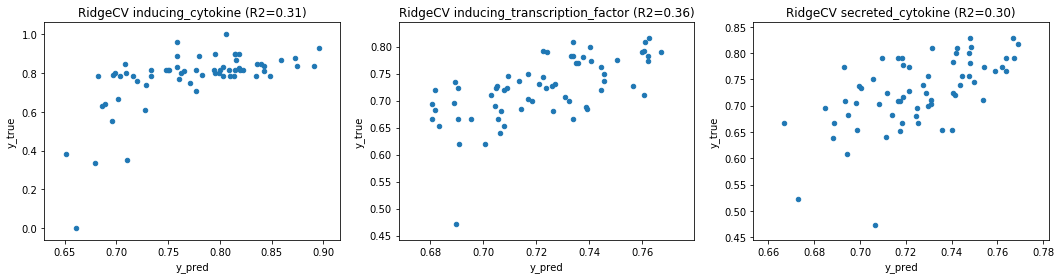

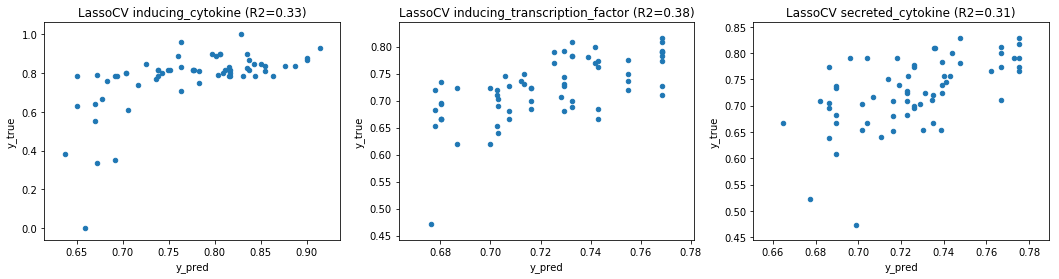

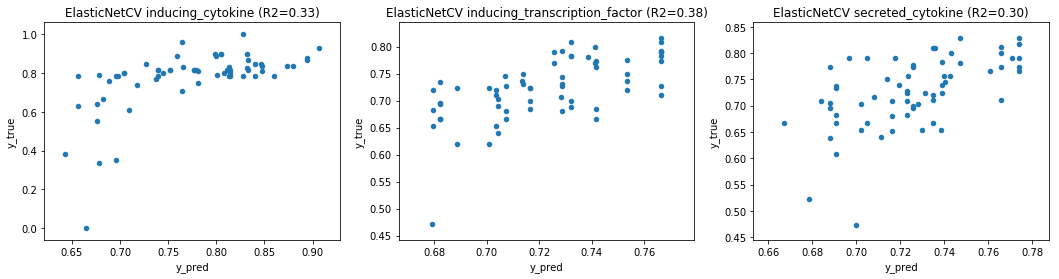

In [23]:
df_coef = pd.concat([
    get_coefs(RidgeCV(normalize=True, cv=5))[1],
    get_coefs(LassoCV(normalize=True, cv=5, random_state=1))[1],
    get_coefs(ElasticNetCV(normalize=True, cv=5, random_state=1))[1]
])

# Add weight for each model as R2 for model / R2 for all models
df_coef = df_coef.groupby('task', group_keys=False).apply(lambda g: g.assign(weight=(g['score'] / g['score'].sum())))
df_coef = df_coef.set_index(['task', 'score', 'est', 'weight'])

df_coef.head()

In [24]:
df_coef_lng = df_coef.rename_axis('parameter', axis='columns').stack().rename('value').reset_index()
df_coef_lng['weighted_value'] = df_coef_lng['value'] * df_coef_lng['weight']
df_coef_lng.head()

,task,score,est,weight,parameter,value,weighted_value
0,inducing_cytokine,0.31289,RidgeCV,0.320951,bidirectional:False,0.000000,0.000000
1,inducing_cytokine,0.31289,RidgeCV,0.320951,cell_type:LSTM,0.000000,0.000000
2,inducing_cytokine,0.31289,RidgeCV,0.320951,dropout:0.0,-0.004978,-0.001598
3,inducing_cytokine,0.31289,RidgeCV,0.320951,dropout:0.25,0.001889,0.000606
4,inducing_cytokine,0.31289,RidgeCV,0.320951,dropout:0.5,0.028474,0.009139


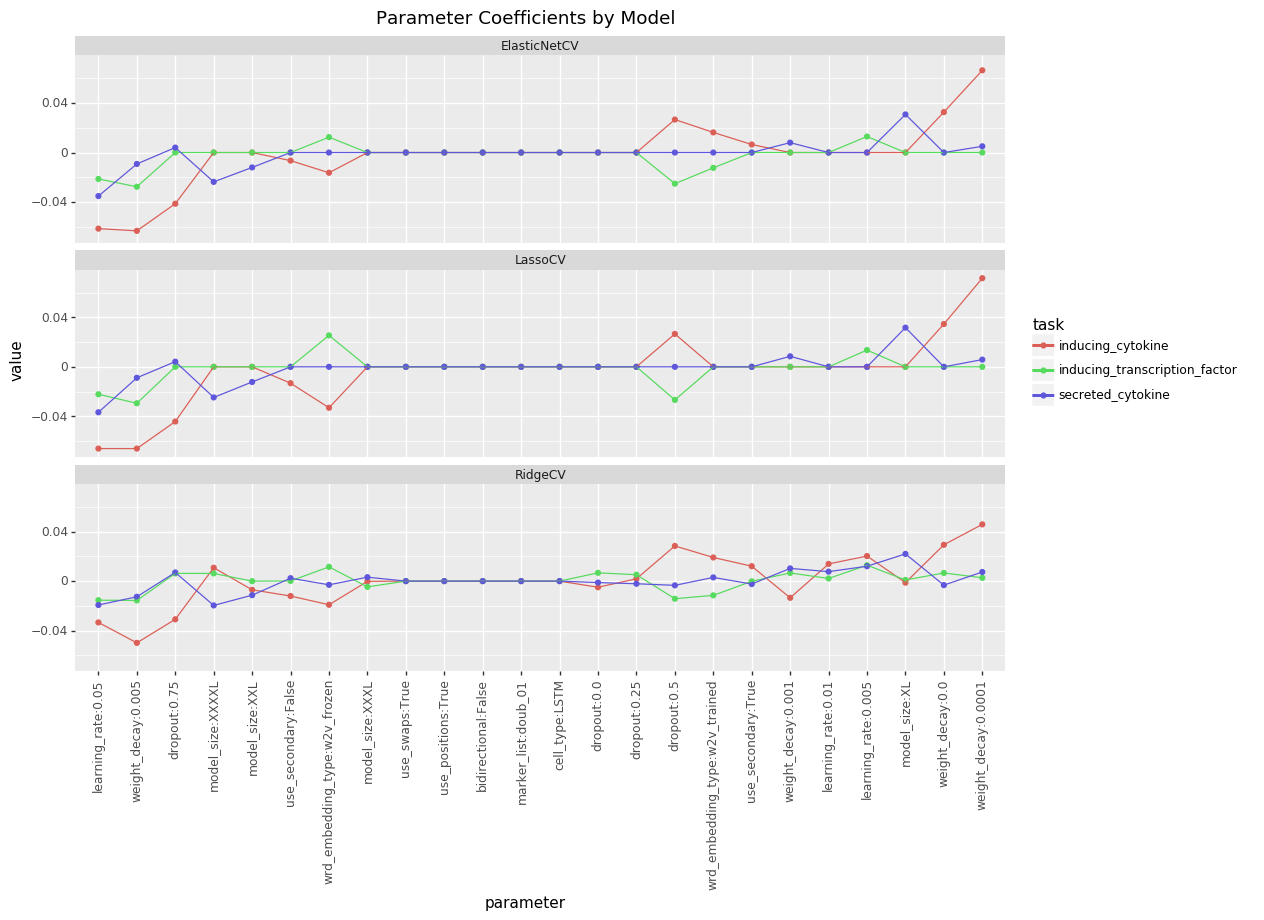

<ggplot: (8784222004039)>

In [25]:
(
    pn.ggplot(
        df_coef_lng.assign(parameter=lambda df: pd.Categorical(
            df['parameter'], ordered=True, 
            categories=df.groupby('parameter')['weighted_value'].mean().sort_values().index
        )), 
        pn.aes(x='parameter', y='value', fill='task', color='task', group='task')
    ) + 
    pn.geom_point() +
    pn.geom_line() + 
    pn.ggtitle('Parameter Coefficients by Model') + 
    pn.facet_wrap('~ est', ncol=1) +
    pn.theme(figure_size=(12, 8), axis_text_x=pn.element_text(rotation=90, hjust=.5))
)

### Score Distributions

In [26]:
df_score = pd.concat([v[1].assign(task=k) for k, v in results.items()])
df_score.head()

,iteration,type,metric,value,task
0,0,,epoch,2.000000,inducing_cytokine
1,0,test,accuracy,0.500000,inducing_cytokine
2,0,test,ct,28.000000,inducing_cytokine
3,0,test,f1,0.461538,inducing_cytokine
4,0,test,loss,0.682699,inducing_cytokine


In [27]:
# Label balance
df_lbl = df_cand.assign(label=lambda df: np.where(df['label'] > .5, 1, 0))
pd.concat([
    df_lbl.assign(agg='count').groupby(['task', 'split', 'agg'])['label'].value_counts().unstack([-2, -1]),
    df_lbl.assign(agg='percent').groupby(['task', 'split', 'agg'])['label'].value_counts(normalize=True).unstack([-2, -1]).round(2)
], axis=1)

agg                                  count        percent      
label                                    0      1       0     1
task                          split                            
inducing_cytokine             test      86     14    0.86  0.14
                              train  38743   9913    0.80  0.20
                              val       84     13    0.87  0.13
inducing_transcription_factor test      82     18    0.82  0.18
                              train  16520   6463    0.72  0.28
                              val       95     22    0.81  0.19
secreted_cytokine             test      80     20    0.80  0.20
                              train  34024  14503    0.70  0.30
                              val       79     19    0.81  0.19

In [28]:
# Scores at best validation F1 iteration
def get_scores_table(metrics):
    df_bal = (
        df_lbl.assign(metric='balance').groupby(['task', 'metric', 'split'])['label'].value_counts(normalize=True)
        .unstack().round(2)[1].unstack([-2, -1])
    )
    return (
        df_score
        .pivot_table(index=['task', 'iteration'], columns=['metric', 'type'], values='value')
        .pipe(lambda df: df.groupby('task').apply(lambda g: g.iloc[np.argmax(g[('f1', 'validation')].values)])[metrics])
        .round(2)
        .pipe(lambda df: pd.concat([df, df_bal], axis=1, sort=True))
        .style.background_gradient(cmap='Greens', low=.1, high=.3)
    )

In [29]:
get_scores_table(['ct', 'f1', 'accuracy', 'precision', 'recall'])

In [33]:
# Median scores
p = (
    df_score
    .pipe(lambda df: df[df['metric'].isin(['precision', 'recall', 'f1'])])
    .groupby(['task', 'metric', 'type'])['value'].describe()[['mean', '25%', '50%', '75%']].unstack()['50%'].unstack()[['test', 'validation']]
    .round(3)
    .style.background_gradient(cmap='Greens', low=.3, high=.9)
)

In [34]:
p

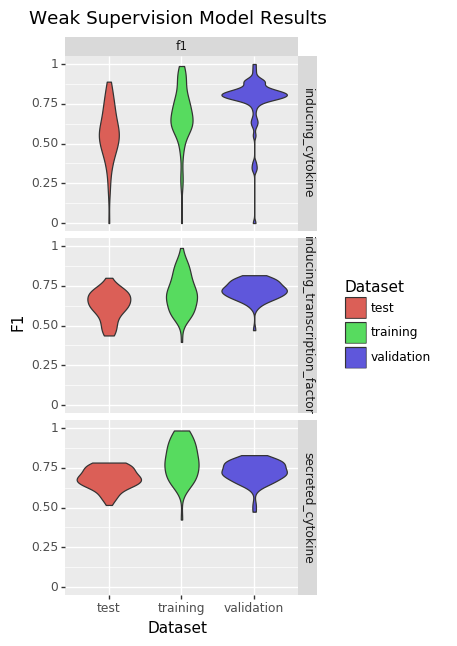

<ggplot: (8738304371383)>

In [41]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.ylim(0, 1) +
    pn.labs(y='F1', title='Weak Supervision Model Results', x='Dataset', fill='Dataset') + 
    pn.facet_grid('task ~ metric', scales='free') + 
    pn.theme(figure_size=(3, 7))
)

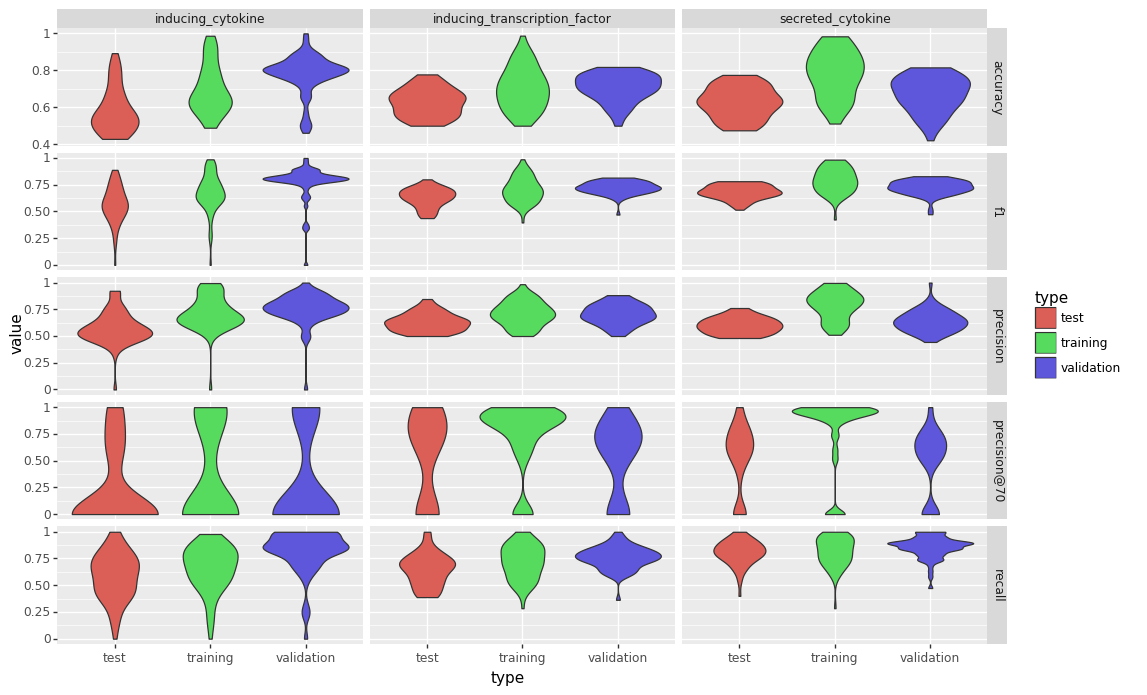

<ggplot: (-9223363298550406284)>

In [43]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1', 'accuracy', 'precision', 'precision@70', 'recall'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 8))
)

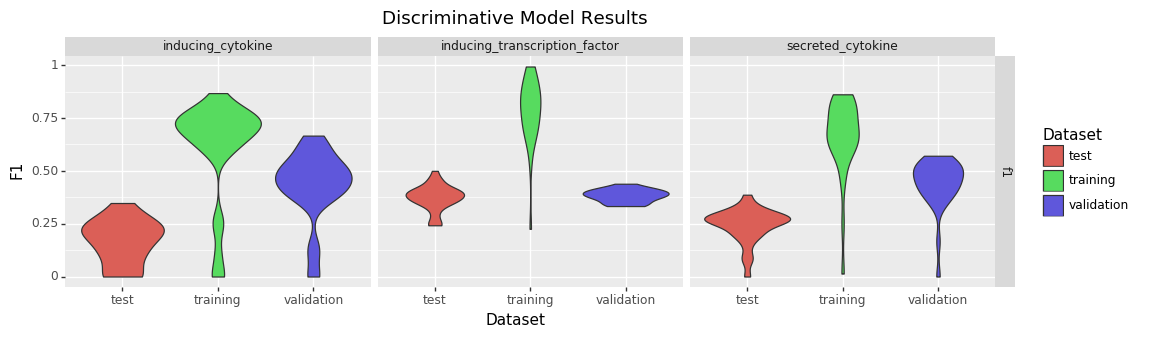

<ggplot: (-9223363247899004265)>

In [66]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.labs(y='F1', title='Discriminative Model Results', x='Dataset', fill='Dataset') + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 3))
)

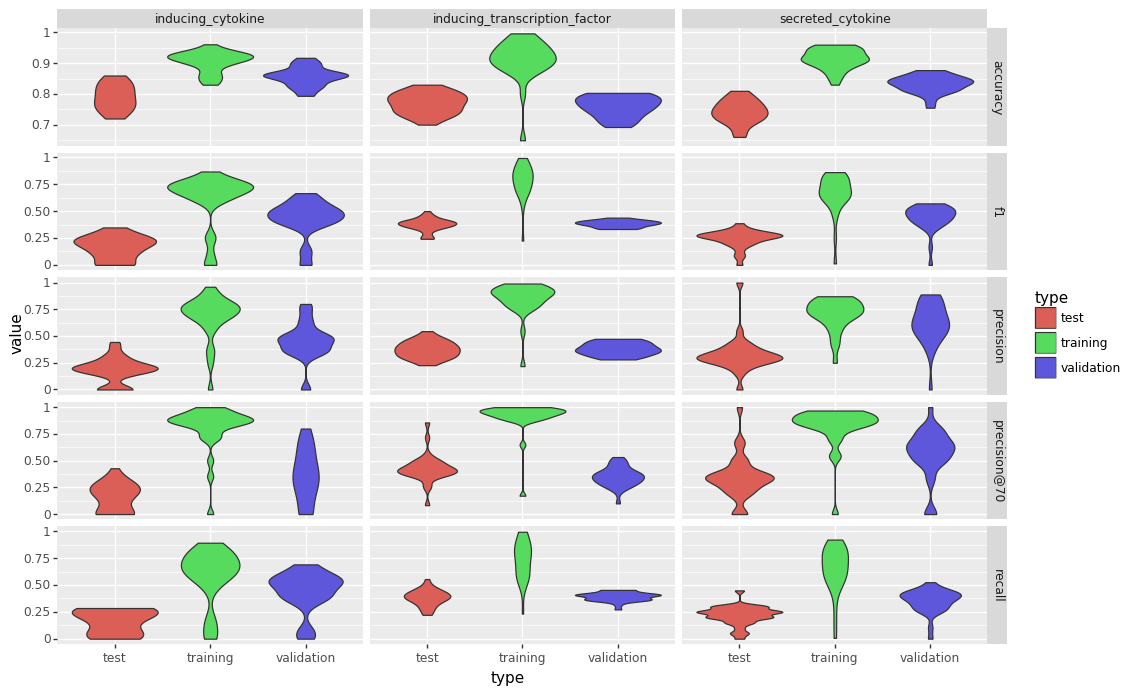

<ggplot: (-9223363247820198603)>

In [59]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1', 'accuracy', 'precision', 'precision@70', 'recall'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 8))
)

In [45]:
# Dump all summaries
pd.set_option('display.max_rows', 100)
(
    df_score
    .pipe(lambda df: df[~df['metric'].isin(['lr', 'loss', 'ct', 'epoch'])])
    .groupby(['task', 'type', 'metric'])['value'].describe()
    .style.background_gradient(subset=pd.IndexSlice[:,'mean'])
)

## Export